### Load Data & libraries

In [165]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg
from tqdm import tqdm
import time
import seaborn as sns
import warnings

# import LibESN
from LibESN.matrix_generator import matrixGenerator
from LibESN.esn import ESN
from LibESN.esn_fit import ridgeFit, ridgeCV
from LibESN.esn_forecast import forecast
from ModelConfidenceSet import ModelConfidenceSet


In [166]:
# Load data
data = read_csv(r"C:\Users\zhouq\OneDrive - Nanyang Technological University\FYP\Codes\FYP\Data\UK_transformed.csv", header = 0, index_col=0, parse_dates=True, dayfirst=False)

# Select 3 exogenous variables 
# RPI, UnE, Ex

# data_new = data[['GDP', 'M1', 'M7','M12']]
data_new = data.dropna()

# change the index to datatime
date_tuples = [(int(date.split()[0]), int(date.split()[1][1])) for date in data_new.index]
start_date = pd.Timestamp(year=date_tuples[0][0], month=(date_tuples[0][1] - 1) * 3 + 1, day=1)
end_date = pd.Timestamp(year=date_tuples[-1][0], month=(date_tuples[-1][1] - 1) * 3 + 1, day=1) + pd.offsets.QuarterEnd()
date_index = pd.date_range(start=start_date, end=end_date, freq='Q')
data_new.index = date_index

# select data before 2020
data_new = data_new[data_new.index < '2020-01-01']
data_new = data_new[['GDP', 'CPI', 'Ex', 'CPA']]
display(data_new)

# Split the data into training and testing sets
train_size = int(len(data_new) * 0.8)

data_new_train, data_new_test = data_new[:train_size], data_new[train_size:]

# Separate GDP into individual dataframes
GDP_fill_data  = pd.DataFrame(data_new['GDP'])
GDP_fill_data.index = GDP_fill_data.index + pd.offsets.QuarterEnd(0)
GDP_fill_data_train, GDP_fill_data_test = GDP_fill_data[:train_size], GDP_fill_data[train_size:]
display(GDP_fill_data)

# Exogenous variables 
x_data = pd.DataFrame(data_new.iloc[:, 1:])
x_data.index = x_data.index + pd.offsets.QuarterEnd(0)
x_data.index = pd.date_range(start=x_data.index[0], periods=len(x_data), freq='Q-DEC')
x_train, x_test = x_data[:train_size], x_data[train_size:]
display(x_train)
display(x_test)


C:\Users\zhouq\AppData\Local\Temp\ipykernel_20076\3243038370.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = read_csv(r"C:\Users\zhouq\OneDrive - Nanyang Technological University\FYP\Codes\FYP\Data\UK_transformed.csv", header = 0, index_col=0, parse_dates=True, dayfirst=False)


,GDP,CPI,Ex,CPA
1997-09-30,0.009249,0.224503,2.2919,0.559616
1997-12-31,0.014646,-0.181944,1.2111,-0.336472
1998-03-31,0.007234,-0.063179,2.1186,-0.223144
1998-06-30,0.006353,0.259511,-0.1129,0.559616
1998-09-30,0.003260,-0.267879,-0.3436,0.000000
...,...,...,...,...
2018-12-31,0.001276,-0.135424,-0.0208,-0.175891
2019-03-31,0.007255,-0.063179,0.9578,0.143101
2019-06-30,0.003221,0.259511,-0.3673,-0.182322
2019-09-30,0.007255,-0.210721,-2.6054,-0.040822


,GDP
1997-09-30,0.009249
1997-12-31,0.014646
1998-03-31,0.007234
1998-06-30,0.006353
1998-09-30,0.003260
...,...
2018-12-31,0.001276
2019-03-31,0.007255
2019-06-30,0.003221
2019-09-30,0.007255


,CPI,Ex,CPA
1997-09-30,0.224503,2.2919,0.559616
1997-12-31,-0.181944,1.2111,-0.336472
1998-03-31,-0.063179,2.1186,-0.223144
1998-06-30,0.259511,-0.1129,0.559616
1998-09-30,-0.267879,-0.3436,0.000000
...,...,...,...
2014-06-30,0.171850,1.3346,-0.133531
2014-09-30,-0.064539,1.1055,0.046520
2014-12-31,-0.245616,-0.7224,0.000000
2015-03-31,-0.701446,2.0988,0.241162


,CPI,Ex,CPA
2015-09-30,0.575364,1.6697,0.033902
2015-12-31,-0.287682,-0.7070,-0.105361
2016-03-31,0.559616,-5.1812,-0.076961
2016-06-30,-0.559616,-1.4510,-0.040822
2016-09-30,0.356675,-6.6960,0.040822
2016-12-31,0.048790,-2.2542,0.039221
2017-03-31,-0.022473,0.4878,-0.080043
2017-06-30,-0.215938,0.9004,-0.042560
2017-09-30,-0.129314,-1.3870,0.042560
2017-12-31,-0.001373,1.1407,0.189242


In [167]:
def normalize_train_test(train, test, return_mu_sig=False):
    m_train = train.mean()
    s_train = (train - train.mean()).std()
    if return_mu_sig:
        return (train - m_train)/s_train, (test - m_train)/s_train, m_train, s_train
    else:
        return (train - m_train)/s_train, (test - m_train)/s_train
    

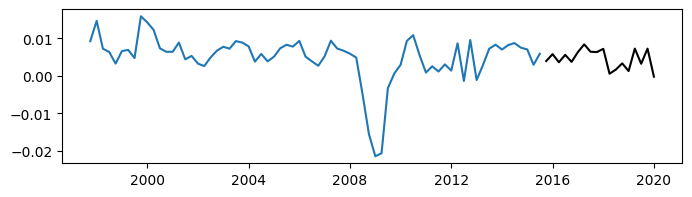

In [168]:
# plot dataset
plt.figure(figsize=(8,2))
plt.plot(GDP_fill_data_train, label = 'Train')
plt.plot(GDP_fill_data_test, label = 'Test', color = 'black')

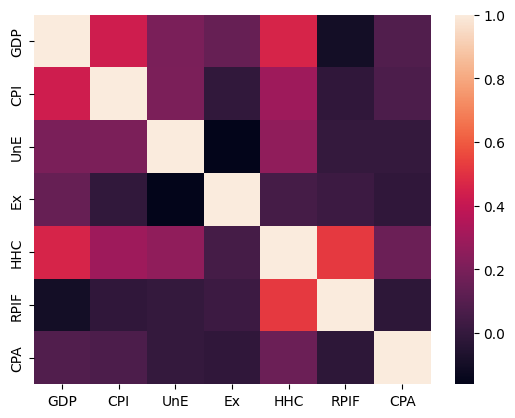

In [169]:
# check correlations between variables
corr_matrix_all = sns.heatmap(data.corr(), annot=False)

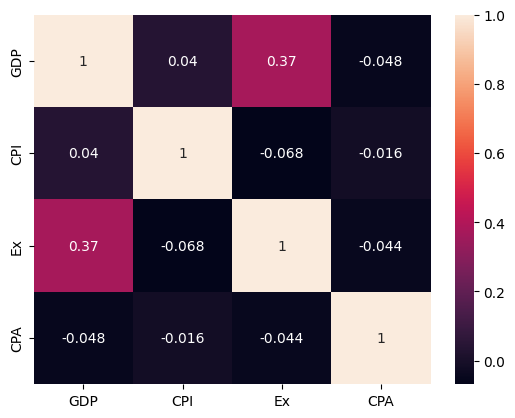

In [170]:
corr_matrix = sns.heatmap(data_new.corr(), annot=True)

### Models

#### ESN

In [171]:
# construct individual ESN
# K is size of inputs 
K = int(x_data.shape[1])
print(int(x_data.shape[1]))

# ESN with reservoir dim = 20 , sparsity = 10/20 (50%)
esn_a = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((20 , 20), dist='sparse_normal', normalize= 'eig', sparsity=10/20, seed=1234), 

    C=matrixGenerator((20, K), dist='sparse_uniform', normalize='norm2', sparsity=10/20, seed=1234), 

    zeta=np.zeros((20, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


3


In [172]:
# build single reservoir ESN with reservoir dim = 30, sparsity = 10/30 (33.3%)

esn_b = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((30, 30), dist='sparse_normal', normalize= 'eig', sparsity=10/30, seed=1234), 

    C=matrixGenerator((30, K), dist='sparse_uniform', sparsity=10/30, normalize='norm2', seed=1234), 

    zeta=np.zeros((30, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


In [173]:
# ESN with reservoir dim = 80 , sparsity = 10/80 (12.5%)
esn_c = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((80 , 80), dist='sparse_normal', normalize= 'eig', sparsity=10/80, seed=1234), 

    C=matrixGenerator((80, K), dist='sparse_uniform', normalize='norm2', sparsity=10/80, seed=1234), 

    zeta=np.zeros((80, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


In [174]:
# ESN with reservoir dim = 120, sparsity = 10/120 (8.3%)
esn_d = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((120, 120), dist='sparse_normal', sparsity=10/120, normalize= 'eig', seed=1234), 

    C=matrixGenerator((120, K), dist='sparse_uniform', sparsity=10/120, normalize='norm2', seed=1234), 

    zeta=np.zeros((120, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


In [175]:
esn_e = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((150, 150), dist='sparse_normal', sparsity=10/150, normalize= 'eig', seed=1234), 

    C=matrixGenerator((150, K), dist='sparse_uniform', sparsity=10/150, normalize='norm2', seed=1234), 

    zeta=np.zeros((150, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)

#### ARX

In [176]:
order = (1, 0, 0)  # AR(1)
arx_model = ARIMA(endog=GDP_fill_data_train, exog=x_train, order=order)
arx_fit = arx_model.fit(method='yule_walker')

#### VAR

In [177]:
# choose an optimal lag 
var_model = sm.tsa.VAR(data_new_train)
var_lag = var_model.select_order(maxlags=8)
var_lag.summary()
# lowest BIC for lag 1

,AIC,BIC,FPE,HQIC
0,-14.85,-14.72,3.537e-07,-14.80
1,-15.48,-14.80*,1.899e-07,-15.21
2,-15.86*,-14.65,1.304e-07*,-15.38*
3,-15.82,-14.07,1.377e-07,-15.13
4,-15.70,-13.41,1.596e-07,-14.80
5,-15.62,-12.79,1.817e-07,-14.51
6,-15.45,-12.07,2.328e-07,-14.12
7,-15.13,-11.21,3.580e-07,-13.59
8,-15.03,-10.58,4.581e-07,-13.28


In [178]:
var_fit = var_model.fit(1)
var_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Apr, 2024
Time:                     03:05:14
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -14.8696
Nobs:                     71.0000    HQIC:                  -15.2535
Log likelihood:           167.519    FPE:                1.84422e-07
AIC:                     -15.5070    Det(Omega_mle):     1.40472e-07
--------------------------------------------------------------------
Results for equation GDP
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.001763         0.000695            2.537           0.011
L1.GDP         0.648165         0.092109            7.037           0.000
L1.CPI         0.002284         0.002266            1.008           0.314
L1.Ex          0

In [179]:
# Check for autocorrelation
# A value near 2 indicates non-autocorrelation; a value toward 0 indicates positive autocorrelation; a value toward 4 indicates negative autocorrelation

from statsmodels.stats.stattools import durbin_watson
out_dw = durbin_watson(var_fit.resid)

for col, val in zip(data_new[:train_size].columns, out_dw):
    print((col), ':', round(val, 2))

GDP : 1.85
CPI : 2.11
Ex : 1.8
CPA : 2.07


### Model Fitting and Fixed Parameter Forecast

##### ESN

In [180]:
def esn_fit(esnModel, GDP_data, exo_data):
    GDP_train, GDP_test = GDP_data[0], GDP_data[1]
    exo_train, exo_test = exo_data[0], exo_data[1]

    #normalize data
    GDP_train, GDP_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_train, GDP_test,
            return_mu_sig=True))
    exo_train, exo_test = normalize_train_test(exo_train, exo_test)

    #cross validation to find lambda
    cv = ridgeCV().cv(model= esnModel, train_data=(exo_train, GDP_train), steps = 1, test_size = 5 )

    #fit model
    esnSingle_fit = esnModel.fit(train_data = (exo_train, GDP_train), method= ridgeFit(cv['cvLambda']), steps =1)

    #forecast
    esnSingle_for = forecast(model = esnModel, forecast_data=exo_test, fit=esnSingle_fit)

    # Compute pointwise forecasts by undoing normalization
    esn_forecast = (esnSingle_for['forecast'])* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy()

    # plot 
    plt.figure(figsize=(8,2))
    plt.plot(data_new.index[:len(GDP_train)], GDP_train, label='Train')
    plt.plot(data_new.index[len(GDP_train):],GDP_test, label='Test')
    plt.plot(data_new.index[len(GDP_train):], esn_forecast[0:len(GDP_test)], label='Predictions')
    plt.grid()
    plt.legend(loc='upper left')
    plt.show()

    #find RMSE
    mse = mean_squared_error(GDP_data[1], esn_forecast[0:len(GDP_test)])
    mae = mean_absolute_error(GDP_data[1], esn_forecast[0:len(GDP_test)])
    rmse = math.sqrt(mse)
    
    #output
    return({'Lambda': cv['cvLambda'], 'rmse': rmse, 'MAE':mae,'forecast': esn_forecast})

                            

In [181]:
# hyperparameter tuning -- to find the best rho and gamma
def esn_fit_tune(GDP_data, exo_data):
    train_size = int(len(GDP_data)*0.8)
    GDP_train, GDP_test = GDP_data[:train_size], GDP_data[train_size:]
    exo_train, exo_test = exo_data[:train_size], exo_data[train_size:]

    #normalize data
    GDP_train, GDP_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_train, GDP_test,
            return_mu_sig=True))
    exo_train, exo_test = normalize_train_test(exo_train, exo_test)

    lambdas_cv = np.zeros((10,10))
    rmse_cv = np.zeros((10,10))

    i_index = 0
    j_index = 0
    for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        j_index = 0
        for j in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
            # setup ESN
            esnModel = ESN(
            None,
            smap=np.tanh, 
            A=matrixGenerator((80, 80), dist='sparse_normal', sparsity=10/80, normalize= 'eig', seed=1234), 

            C=matrixGenerator((80, K), dist='sparse_uniform', sparsity=10/80, normalize='norm2', seed=1234), 

            zeta=np.zeros((80, 1)), 
            rho=i, 
            gamma=j, 
            leak=0,
            )
            
            #cross validation to find lambda
            cv = ridgeCV().cv(model= esnModel, train_data=(exo_train, GDP_train), steps = 1, test_size = 5 )

            #fit model
            esn_fit = esnModel.fit(train_data = (exo_train, GDP_train), method= ridgeFit(cv['cvLambda']), steps =1)

            #forecast for train data
            esn_for = forecast(model = esnModel, forecast_data=exo_test, fit=esn_fit)

            # Compute pointwise forecasts by undoing normalization
            esn_forecast = (esn_for['forecast'])* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy()

            #find RMSE
            mse = mean_squared_error(GDP_test, esn_forecast[0:len(GDP_test)])
            mae = mean_absolute_error(GDP_test, esn_forecast[0:len(GDP_test)])
            rmse = math.sqrt(mse)

            lambdas_cv[i_index , j_index] = (round(cv['cvLambda'],5))
            rmse_cv[i_index , j_index] = (round(rmse,6))

            j_index = j_index + 1
        i_index = i_index+1
        

    min_index = np.unravel_index(np.argmin(rmse_cv, axis=None), rmse_cv.shape)
    min_value = rmse_cv[min_index]
    print('Min RMSE is: ', min_value)
    print('Best rho and gamma index is: ', min_index)
    return{'rmse': rmse, 'lambda':lambdas_cv}
        
                            

In [182]:
# tune once 
# esn_cv = esn_fit_tune(GDP_data= GDP_fill_data_train, exo_data= x_train)

In [183]:
print('rho is:' ,[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1][4])
print('gamma is:', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1][9])

rho is: 0.5
gamma is: 1


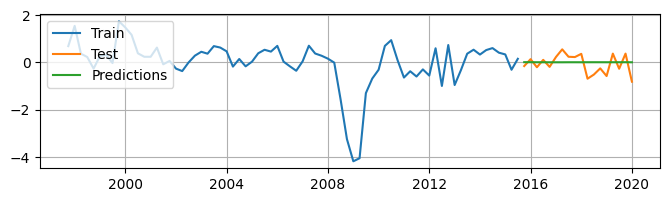

In [184]:
esn_fit_a = esn_fit(esn_a, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

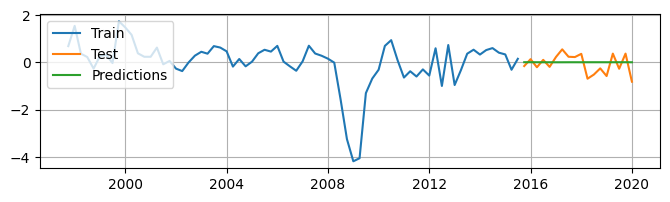

In [185]:
esn_fit_b = esn_fit(esn_b, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

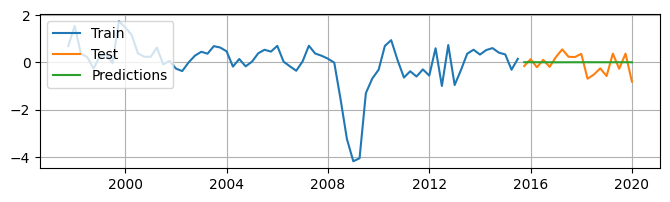

In [186]:
esn_fit_c = esn_fit(esn_c, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

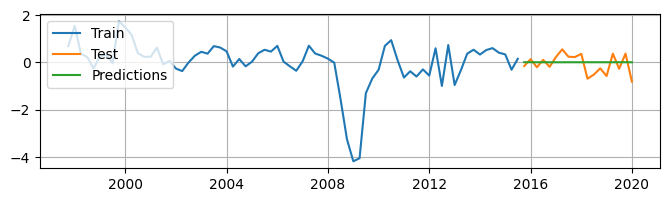

In [187]:
esn_fit_d = esn_fit(esn_d, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

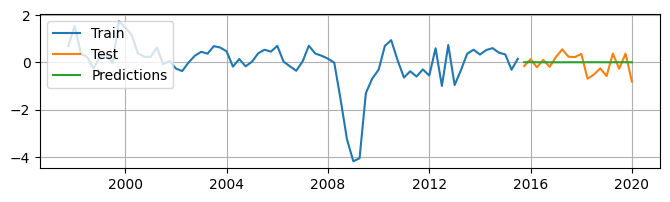

In [188]:
esn_fit_e = esn_fit(esn_e, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test])

In [189]:
rmse_a = esn_fit_a['rmse']
rmse_b = esn_fit_b['rmse']
rmse_c = esn_fit_c['rmse']
rmse_d = esn_fit_d['rmse']
rmse_e = esn_fit_e['rmse']
print("------ RMSE -------")
print(f"ESN_A \t = {round(rmse_a,6)} \t")
print(f"ESN_B \t = {round(rmse_b,6)} \t")
print(f"ESN_C \t = {round(rmse_c,6)} \t")
print(f"ESN_D \t = {round(rmse_d,6)} \t")
print(f"ESN_E \t = {round(rmse_e,6)} \t")

------ RMSE -------
ESN_A 	 = 0.002824 	
ESN_B 	 = 0.00277 	
ESN_C 	 = 0.002888 	
ESN_D 	 = 0.002731 	
ESN_E 	 = 0.002909 	


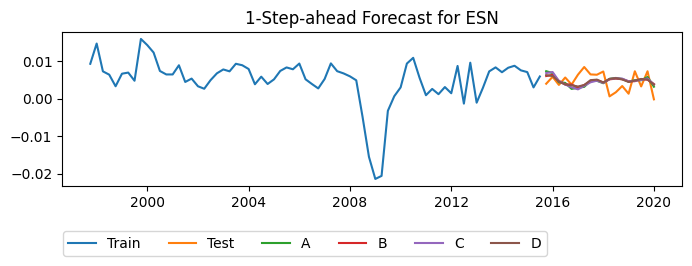

In [190]:
# Plot the actual vs. predicted values
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(GDP_fill_data_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(GDP_fill_data_train):],GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_a['forecast'][0:len(GDP_fill_data_test)], label='A')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_b['forecast'][0:len(GDP_fill_data_test)], label='B')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_c['forecast'][0:len(GDP_fill_data_test)], label='C')
plt.plot(data_new.index[len(GDP_fill_data_train):], esn_fit_d['forecast'][0:len(GDP_fill_data_test)], label='D')
plt.legend(bbox_to_anchor=(-0.01, -0.5), loc='lower left', ncol =6)
plt.title("1-Step-ahead Forecast for ESN")
plt.show()

#### ARX

In [191]:
# make predictions - one step ahead forecast
arx_forecast = arx_fit.predict(start=len(x_train), end=len(data_new)-1, exog=x_test)

# Evaluate the model 
mse_arx = mean_squared_error(GDP_fill_data_test, arx_forecast)
print('MSE: '+str(mse_arx))

mae_arx = mean_absolute_error(GDP_fill_data_test, arx_forecast)
print('MAE: '+str(mae_arx))

rmse_arx = math.sqrt(mse_arx)
print('RMSE: '+str(rmse_arx))

MSE: 7.539297986448428e-06
MAE: 0.002212938538586317
RMSE: 0.002745778211445423


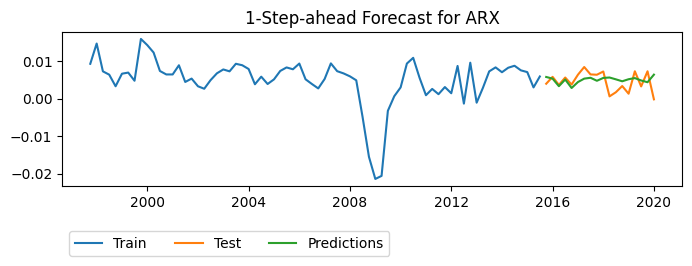

In [192]:
# Plot the actual vs. predicted values
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(x_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(x_train):], GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(x_train):], arx_forecast, label='Predictions')
plt.title("1-Step-ahead Forecast for ARX")
plt.legend(bbox_to_anchor=(0, -0.5), loc='lower left', ncol =3)
plt.show()

#### VAR

In [193]:
lag_order = var_fit.k_ar
print(lag_order)

# one step ahead GDP forecast
var_forecast = np.zeros((len(GDP_fill_data_test),4))

for i in range(len(GDP_fill_data_test)):
    if i > 0:
        var_fore = var_fit.forecast(data_new_test.values[[i-1]], 1)
        var_forecast[i]= var_fore
    else:
        var_fore = var_fit.forecast(data_new_train.values[-lag_order:], 1)
        var_forecast[i]= var_fore


1


In [194]:
print(var_forecast[:,0])
rmse_var = np.sqrt(mean_squared_error(GDP_fill_data_test,var_forecast[:,0]))
print('RMSE: '+str(rmse_var))

[0.00801713 0.0063682  0.00463311 0.00306487 0.00347939 0.00183585
 0.00490487 0.00746315 0.00589257 0.00488512 0.00675258 0.00256145
 0.00297945 0.00334353 0.00245916 0.00661371 0.00446753 0.00481836]
RMSE: 0.0031164804860199396


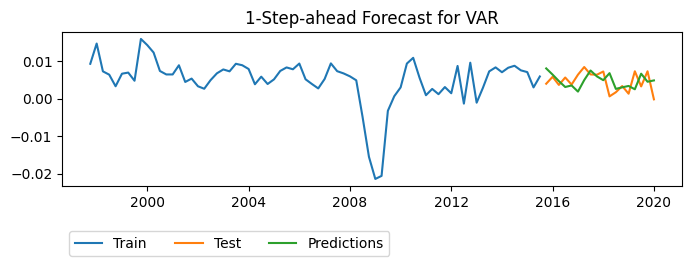

In [195]:
# Plot the actual vs. predicted values
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(x_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(x_train):], GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(x_train):], var_forecast[:,0], label='Predictions')
plt.title("1-Step-ahead Forecast for VAR")
plt.legend(bbox_to_anchor=(0, -0.5), loc='lower left', ncol =3)
plt.show()

#### Summary of RMSE

In [196]:
rmse_a = esn_fit_a['rmse']
rmse_b = esn_fit_b['rmse']
rmse_c = esn_fit_c['rmse']
rmse_d = esn_fit_d['rmse']
rmse_e = esn_fit_e['rmse']
print("------ RMSE -------")
print(f"ESN_A \t = {round(rmse_a,6)} \t")
print(f"ESN_B \t = {round(rmse_b,6)} \t")
print(f"ESN_C \t = {round(rmse_c,6)} \t")
print(f"ESN_D \t = {round(rmse_d,6)} \t")
print(f"ESN_E \t = {round(rmse_e,6)} \t")
print(f"ARX \t = {round(rmse_arx,6)} \t")
print(f"VAR \t = {round(rmse_var,6)} \t")

------ RMSE -------
ESN_A 	 = 0.002824 	
ESN_B 	 = 0.00277 	
ESN_C 	 = 0.002888 	
ESN_D 	 = 0.002731 	
ESN_E 	 = 0.002909 	
ARX 	 = 0.002746 	
VAR 	 = 0.003116 	


### Expanding window forecast

#### ESN 

In [197]:
def esn_ew_fit(esnModel, Lambda, GDP_data, x_data, retune=False):
    GDP_fill_data_train = GDP_data[0]
    GDP_fill_data_test = GDP_data[1]

    x_train = x_data[0]
    x_test = x_data[1]

    GDP_test_dates = GDP_fill_data_test.index

    # calculate lambdas
    if retune:
        Lambdas = []
    else:
        Lambdas = Lambda

    forecast_ew = np.zeros((len(GDP_fill_data_test), 1))
    for j in tqdm(range(len(GDP_fill_data_test)), desc="EW", position=1, leave=False):
        if j > 0:
            #update data sets    
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:j,]
            ])
            x_train_j = pd.concat([
                x_train, 
                x_test.iloc[0:j,]
            ])
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            x_test_j = x_test.iloc[[j],]
        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            x_train_j = x_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            x_test_j = x_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        x_train_j, x_test_j = (
            normalize_train_test(x_train_j, x_test_j)
        )

        if retune:
            Lambda_j = ridgeCV().cv(
                model= esnModel, 
                train_data=(x_train_j, GDP_fill_data_train_j), 
                steps = 1, 
                test_size = 5)
            
            Lambda_j = Lambda_j['cvLambda']
            Lambdas.append(Lambda_j)
            
        else:
            Lambda_j = Lambda

        #fit model
        esnSingle_fit = esnModel.fit(
            train_data = (x_train_j, GDP_fill_data_train_j), 
            method= ridgeFit(Lambda_j), 
            steps =1)

        #point forecast
        esnSingle_for = forecast(
            model = esnModel, 
            forecast_data=x_test_j, 
            fit=esnSingle_fit)

        forecast_ew[j] = (esnSingle_for['forecast'][0])* sig_j + mu_j #undo normalizing 
        #print(j)

    forecast_ew = pd.DataFrame(data=forecast_ew, index=GDP_test_dates,)
    mse_ew = mean_squared_error(GDP_fill_data_test, forecast_ew)
    rmse_ew = math.sqrt(mse_ew)
    
    return {'forecast': forecast_ew, 'rmse': rmse_ew, 'lambda': Lambdas}
   

In [198]:
# use pinv and set lambda = 0
esn_A_ew_0 = esn_ew_fit(
    esnModel=esn_a, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_B_ew_0 = esn_ew_fit(
    esnModel=esn_b, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_C_ew_0 = esn_ew_fit(
    esnModel=esn_c, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_D_ew_0 = esn_ew_fit(
    esnModel=esn_d, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_E_ew_0 = esn_ew_fit(
    esnModel=esn_e, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

In [199]:
# evaluate forcast
print("--- RMSE for EW, Lambda = 0 ---")
print(f"ESN_A_EW = {esn_A_ew_0['rmse']} \t")
print(f"ESN_B_EW = {esn_B_ew_0['rmse']} \t")
print(f"ESN_C_EW = {esn_C_ew_0['rmse']} \t")
print(f"ESN_D_EW = {esn_D_ew_0['rmse']} \t")
print(f"ESN_E_EW = {esn_E_ew_0['rmse']} \t")

--- RMSE for EW, Lambda = 0 ---
ESN_A_EW = 0.006062519577113399 	
ESN_B_EW = 0.011962411698546055 	
ESN_C_EW = 0.03598837680206784 	
ESN_D_EW = 0.030161222135808734 	
ESN_E_EW = 0.02484666164448569 	


In [200]:
# using a fixed lambda -- same as fixed parms
esn_A_ew = esn_ew_fit(
    esnModel=esn_a, 
    Lambda=esn_fit_a['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_B_ew = esn_ew_fit(
    esnModel=esn_b, 
    Lambda=esn_fit_b['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_C_ew = esn_ew_fit(
    esnModel=esn_c, 
    Lambda=esn_fit_c['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_D_ew = esn_ew_fit(
    esnModel=esn_d, 
    Lambda=esn_fit_d['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_E_ew = esn_ew_fit(
    esnModel=esn_e, 
    Lambda=esn_fit_e['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

In [201]:
# evaluate forcast for fixed lambda
print("---------- RMSE --------------")
print(f"ESN_A_EW = {esn_A_ew['rmse']} \t")
print(f"ESN_B_EW = {esn_B_ew['rmse']} \t")
print(f"ESN_C_EW = {esn_C_ew['rmse']} \t")
print(f"ESN_D_EW = {esn_D_ew['rmse']} \t")
print(f"ESN_E_EW = {esn_E_ew['rmse']} \t")

---------- RMSE --------------
ESN_A_EW = 0.002792063927201043 	
ESN_B_EW = 0.0027525434395746177 	
ESN_C_EW = 0.002837552919533495 	
ESN_D_EW = 0.0027111160316419317 	
ESN_E_EW = 0.00286943591085364 	


#### ARX

In [202]:
hist_exo = x_train.copy(deep=True)
hist_endo = GDP_fill_data_train.copy(deep=True)
arx_fore_ew = list()
 
#ignore value warnings
warnings.filterwarnings("ignore")

for t in range(len(x_test)):
 # model set up and fit with updated train data
 model = ARIMA(endog=hist_endo, exog=hist_exo, order=order)
 fit = model.fit(method='yule_walker')

 #point forecast
 output = fit.forecast(steps=1, exog = x_test.iloc[t,:])
 
 # update training dataset for the next prediction
 hist_exo = hist_exo._append(x_test.iloc[t,:],ignore_index=False)
 hist_endo = hist_endo._append(GDP_fill_data_test.iloc[t,], ignore_index=False)
 
 # add forecast value to list
 arx_fore_ew.append(output.tolist()[0]) 
 # obs = test.iloc[t,0] # actual
 # print('predicted=%f, actual=%f' % (output, obs))
 
warnings.resetwarnings()

# evaluate forecasts
arx_rmse_ew = math.sqrt(mean_squared_error(GDP_fill_data_test, arx_fore_ew))
print('RMSE: '+str(arx_rmse_ew))

RMSE: 0.003170918948124754


#### VAR

In [203]:
var_fore_ew = np.zeros((len(GDP_fill_data_test)))
data_train_ew = data_new_train.copy(deep=True)
data_test_ew = data_new_test.copy(deep=True)

warnings.filterwarnings("ignore")
for i in range(len(x_test)):
    var_model = sm.tsa.VAR(data_train_ew)
    var_fit = var_model.fit(1) # VAR(1)

    #point forecast
    if i > 0:
        var_fore = var_fit.forecast(data_test_ew.values[[i-1]], 1)
        var_fore_ew[i]= var_fore[0][0]

    else: # for i = 0 case, use last value in train 
        var_fore = var_fit.forecast(data_new_train.values[-lag_order:], 1)
        var_fore_ew[i]= var_fore[0][0]
    
    # update training dataset for the next prediction
    data_train_ew = data_train_ew._append(data_test_ew.iloc[i,:],ignore_index=False)
    
warnings.resetwarnings()

# Evaluate     
var_rmse_ew = np.sqrt(mean_squared_error(GDP_fill_data_test, var_fore_ew))
print('RMSE:', var_rmse_ew)

RMSE: 0.003102952677339997


#### Summary of RMSE for EW

In [204]:
# evaluate forcast
print("--- RMSE for EW ---")
print(f"ESN_A_EW = {round(esn_A_ew['rmse'],6)} \t")
print(f"ESN_B_EW = {round(esn_B_ew['rmse'],6)} \t")
print(f"ESN_C_EW = {round(esn_C_ew['rmse'],6)} \t")
print(f"ESN_D_EW = {round(esn_D_ew['rmse'],6)} \t")
print(f"ESN_E_EW = {round(esn_E_ew['rmse'],6)} \t")
print(f"ARX_EW \t = {round(arx_rmse_ew,6)} \t")
print(f"VAR_EW \t = {round(var_rmse_ew,6)} \t")

--- RMSE for EW ---
ESN_A_EW = 0.002792 	
ESN_B_EW = 0.002753 	
ESN_C_EW = 0.002838 	
ESN_D_EW = 0.002711 	
ESN_E_EW = 0.002869 	
ARX_EW 	 = 0.003171 	
VAR_EW 	 = 0.003103 	


### Rolling Window Forecast

#### ESN

In [205]:
def esn_rw_fit(esnModel, Lambda, GDP_data, x_data, retune=False):
    GDP_fill_data_train = GDP_data[0]
    GDP_fill_data_test = GDP_data[1]

    x_train = x_data[0]
    x_test = x_data[1]

    GDP_test_dates = GDP_fill_data_test.index
    GDP_dates = GDP_fill_data_train.index.append(GDP_fill_data_test.index)

    # calculate lambdas
    if retune:
        Lambdas = []
    else:
        Lambdas = Lambda


    forecast_rw = np.zeros((len(GDP_fill_data_test), 1))
    for j in tqdm(range(len(GDP_fill_data_test)), desc="RW", position=1, leave=False):
        if j > 0:
            #update data sets    
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:j,]
            ]).iloc[j:,]
            x_train_j = pd.concat([
                x_train, 
                x_test.iloc[0:j,]
            ]).iloc[j:,]
            
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            x_test_j = x_test.iloc[[j],]

        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            x_train_j = x_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            x_test_j = x_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        x_train_j, x_test_j = (
            normalize_train_test(x_train_j, x_test_j)
        )

        if retune:
            Lambda_j = ridgeCV().cv(
                model= esnModel, 
                train_data=(x_train_j, GDP_fill_data_train_j), 
                steps = 1, 
                test_size = 5)
            
            Lambda_j = Lambda_j['cvLambda']
            Lambdas.append(Lambda_j)
            
        else:
            Lambda_j = Lambda

        #fit model
        esnSingle_fit = esnModel.fit(
            train_data = (x_train_j, GDP_fill_data_train_j), 
            method= ridgeFit(Lambda_j), 
            steps =1)

        #point forecast
        esnSingle_for = forecast(
            model = esnModel, 
            forecast_data=x_test_j, 
            fit=esnSingle_fit)

        forecast_rw[j] = (esnSingle_for['forecast'][0])* sig_j + mu_j #undo normalizing 
        #print(j)

    forecast_rw = pd.DataFrame(data=forecast_rw, index=GDP_test_dates,)
    mse_rw = mean_squared_error(GDP_fill_data_test, forecast_rw)
    rmse_rw = math.sqrt(mse_rw)
    
    return {'forecast': forecast_rw, 'rmse': rmse_rw, 'lambda': Lambdas}
   

In [206]:
# using lamnda = 0
esn_A_rw_0 = esn_rw_fit(
    esnModel=esn_a, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_B_rw_0 = esn_rw_fit(
    esnModel=esn_b, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_C_rw_0 = esn_rw_fit(
    esnModel=esn_c, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_D_rw_0 = esn_rw_fit(
    esnModel=esn_d, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_E_rw_0 = esn_rw_fit(
    esnModel=esn_e, 
    Lambda=0, 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

In [207]:
# evaluate forcast for lambda = 0 
print("------ RMSE for RW, lambda = 0 -------")
print(f"ESN_A_RW = {esn_A_rw_0['rmse']} \t")
print(f"ESN_B_RW = {esn_B_rw_0['rmse']} \t")
print(f"ESN_C_RW = {esn_C_rw_0['rmse']} \t")
print(f"ESN_D_RW = {esn_D_rw_0['rmse']} \t")
print(f"ESN_E_RW = {esn_E_rw_0['rmse']} \t")

------ RMSE for RW, lambda = 0 -------
ESN_A_RW = 0.006502448363242805 	
ESN_B_RW = 0.01283784527687071 	
ESN_C_RW = 0.033315357431126645 	
ESN_D_RW = 0.03559686314348572 	
ESN_E_RW = 0.035944755191856394 	


In [208]:
# using a fixed lambda
esn_A_rw = esn_rw_fit(
    esnModel=esn_a, 
    Lambda=esn_fit_a['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_B_rw = esn_rw_fit(
    esnModel=esn_b, 
    Lambda=esn_fit_b['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_C_rw = esn_rw_fit(
    esnModel=esn_c, 
    Lambda=esn_fit_c['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_D_rw = esn_rw_fit(
    esnModel=esn_d, 
    Lambda=esn_fit_d['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

esn_E_rw = esn_rw_fit(
    esnModel=esn_e, 
    Lambda=esn_fit_e['Lambda'], 
    GDP_data=[GDP_fill_data_train,GDP_fill_data_test],
    x_data=[x_train, x_test],
    retune=False,
)

In [209]:
# evaluate forcast for lambda = fixed 
print("--------- RMSE for RW -----------")
print(f"ESN_A_RW = {esn_A_rw['rmse']} \t")
print(f"ESN_B_RW = {esn_B_rw['rmse']} \t")
print(f"ESN_C_RW = {esn_C_rw['rmse']} \t")
print(f"ESN_D_RW = {esn_D_rw['rmse']} \t")
print(f"ESN_E_RW = {esn_E_rw['rmse']} \t")

--------- RMSE for RW -----------
ESN_A_RW = 0.0026793892161385982 	
ESN_B_RW = 0.0026542871248805586 	
ESN_C_RW = 0.0027134552139882724 	
ESN_D_RW = 0.002597967114897721 	
ESN_E_RW = 0.0027754843795838153 	


#### ARX

In [210]:
hist_exo_rw = x_train.copy(deep=True)
hist_endo_rw = GDP_fill_data_train.copy(deep=True)
arx_fore_rw = list()

warnings.filterwarnings("ignore")

for t in range(len(x_test)):
 # model set up and fit
 model = ARIMA(endog=hist_endo_rw, exog=hist_exo_rw, order=order)
 fit = model.fit(method='yule_walker')
 output = fit.forecast(steps=1, exog = x_test.iloc[t,])
 
 # update training dataset with observed data
 hist_exo = hist_exo.iloc[1:]._append(x_test.iloc[t,:],ignore_index=False)
 hist_endo = hist_endo.iloc[1:]._append(GDP_fill_data_test.iloc[t,], ignore_index=False)
 
 arx_fore_rw.append(output.tolist()[0]) 

warnings.resetwarnings()

# evaluate forecasts
arx_rmse_rw = math.sqrt(mean_squared_error(GDP_fill_data_test, arx_fore_rw))
print('RMSE: '+str(arx_rmse_rw))

RMSE: 0.0028304626150975547


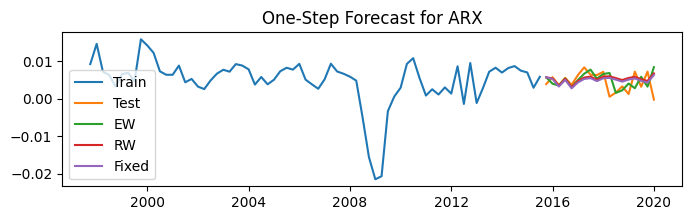

In [211]:
# plot forecasts against actual outcomes
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(x_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(x_train):], GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(x_train):], arx_fore_ew, label='EW')
plt.plot(data_new.index[len(x_train):], arx_fore_rw, label='RW')
plt.plot(data_new.index[len(x_train):], arx_forecast, label='Fixed')
plt.title("One-Step Forecast for ARX")
plt.legend()
plt.show()

#### VAR

In [212]:
var_fore_rw = np.zeros((len(GDP_fill_data_test)))
data_train_rw = data_new_train.copy(deep=True)
data_test_rw = data_new_test.copy(deep=True)

warnings.filterwarnings("ignore")
for i in range(len(x_test)):
    var_model = sm.tsa.VAR(data_train_rw)
    var_fit = var_model.fit(1) # VAR(1)

    #point forecast
    if i > 0:
        var_fore = var_fit.forecast(data_test_rw.values[[i-1]], 1)
        var_fore_rw[i]= var_fore[0][0]

    else: # for i = 0 case, use last value in train 
        var_fore = var_fit.forecast(data_new_train.values[-lag_order:], 1)
        var_fore_rw[i]= var_fore[0][0]
    
    # update training dataset for the next prediction
    data_train_rw = data_train_rw._append(data_test_ew.iloc[i,:],ignore_index=False).iloc[1:,:]
    
warnings.resetwarnings()

# Evaluate     
var_rmse_rw = np.sqrt(mean_squared_error(GDP_fill_data_test, var_fore_rw))
print('RMSE:', var_rmse_rw)

RMSE: 0.0029723138701748006


#### Summary of RMSE

In [213]:
rmse_sum_arx = {'Forecast Methods': ['Fixed Parameters', 'Expanding Window', 'Rolling Window'], 
            'RMSE': [rmse_arx, arx_rmse_ew, arx_rmse_rw ]}

print(pd.DataFrame(rmse_sum_arx).to_string(index=False))

Forecast Methods     RMSE
Fixed Parameters 0.002746
Expanding Window 0.003171
  Rolling Window 0.002830


In [214]:
rmse_sum_var = {'Forecast Methods': ['Fixed Parameters', 'Expanding Window', 'Rolling Window'], 
            'RMSE': [rmse_var, var_rmse_ew, var_rmse_rw ]}

print(pd.DataFrame(rmse_sum_var).to_string(index=False))

Forecast Methods     RMSE
Fixed Parameters 0.003116
Expanding Window 0.003103
  Rolling Window 0.002972


In [215]:
# evaluate forcast
print("--- RMSE for RW ---")
print(f"ESN_A_RW = {round(esn_A_rw['rmse'],6)} \t")
print(f"ESN_B_RW = {round(esn_B_rw['rmse'],6)} \t")
print(f"ESN_C_RW = {round(esn_C_rw['rmse'],6)} \t")
print(f"ESN_D_RW = {round(esn_D_rw['rmse'],6)} \t")
print(f"ESN_E_RW = {round(esn_E_rw['rmse'],6)} \t")
print(f"ARX_RW \t = {round(arx_rmse_rw,6)} \t")
print(f"VAR_RW \t = {round(var_rmse_rw,6)} \t")

--- RMSE for RW ---
ESN_A_RW = 0.002679 	
ESN_B_RW = 0.002654 	
ESN_C_RW = 0.002713 	
ESN_D_RW = 0.002598 	
ESN_E_RW = 0.002775 	
ARX_RW 	 = 0.00283 	
VAR_RW 	 = 0.002972 	


### Direct Mutli-step Forecast

#### ESN

In [216]:
# 8 steps ahead 
from LibESN.esn_forecast import forecastDirectMultistep
def esn_fit_multistep(esnModel, GDP_data, exo_data, n_step):
    GDP_train, GDP_test = GDP_data[0], GDP_data[1]
    exo_train, exo_test = exo_data[0], exo_data[1]

    #normalize data
    GDP_train, GDP_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_train, GDP_test,
            return_mu_sig=True))
    exo_train, exo_test = normalize_train_test(exo_train, exo_test)

    #cross validation to find lambda
    cv = ridgeCV().cvDirectMultistep(
        model= esnModel, 
        train_data=(exo_train, GDP_train), 
        steps = n_step, 
        test_size = 5 )

    #fit model
    esn_fit_multi = esnModel.fitDirectMultistep(
        train_data = (exo_train, GDP_train), 
        method= ridgeFit(cv['cvLambda']), 
        steps =n_step)

    #forecast
    esn_for = forecastDirectMultistep(
        model = esnModel, 
        forecast_data=exo_test, 
        fit=esn_fit_multi)
    
    #undo norm
    esn_for['forecast'] = esn_for['forecast']* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy()

    # Compute pointwise forecasts
    esnSingle_fix_forecast = (esn_for['forecast'][0]* GDP_sig_train.to_numpy() + GDP_mu_train.to_numpy())

    #output
    return({'Lambda': cv['cvLambda'], 
            'Point forecast': esnSingle_fix_forecast, 
            'forecast':esn_for['forecast'],
            'fit': esn_fit_multi})

                            

In [217]:
esn_a_multistep = esn_fit_multistep(esn_a, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [218]:
esn_b_multistep = esn_fit_multistep(esn_b, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [219]:
esn_c_multistep = esn_fit_multistep(esn_c, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [220]:
esn_d_multistep = esn_fit_multistep(esn_d, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [221]:
esn_e_multistep = esn_fit_multistep(esn_e, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], n_step = 8)

In [222]:
def hStepRMSFE(forecasts_df):
    T = len(forecasts_df)
    steps = len(forecasts_df.columns)
    hStep_rmse = np.zeros((steps))
    for h, c in enumerate(forecasts_df.columns):
        hStep_rmse[h] = np.sqrt(np.mean(np.square(
            np.squeeze(GDP_fill_data_test.to_numpy()) - forecasts_df[[c]].to_numpy()
        )[h:(T-steps+h+1)]))
    return pd.DataFrame(data=hStep_rmse, index=range(1, 1+steps))


In [244]:
esn_a_multi_for = np.squeeze(esn_a_multistep['forecast'])
esn_a_multi_for = pd.DataFrame(esn_a_multi_for)
# display(esn_a_multi_for)
print('RMSE for A:',hStepRMSFE(esn_a_multi_for))

esn_b_multi_for = np.squeeze(esn_b_multistep['forecast'])
esn_b_multi_for = pd.DataFrame(esn_b_multi_for)
print('RMSE for B:',hStepRMSFE(esn_b_multi_for))

esn_c_multi_for = np.squeeze(esn_c_multistep['forecast'])
esn_c_multi_for = pd.DataFrame(esn_c_multi_for)
print('RMSE for C:',hStepRMSFE(esn_c_multi_for))

esn_d_multi_for = np.squeeze(esn_d_multistep['forecast'])
esn_d_multi_for = pd.DataFrame(esn_d_multi_for)
print('RMSE for D:',hStepRMSFE(esn_d_multi_for))

esn_e_multi_for = np.squeeze(esn_e_multistep['forecast'])
esn_e_multi_for = pd.DataFrame(esn_e_multi_for)
print('RMSE for E:',hStepRMSFE(esn_e_multi_for))


RMSE for A:           0
1  0.002853
2  0.002524
3  0.002497
4  0.002569
5  0.002497
6  0.002495
7  0.002494
8  0.002494
RMSE for B:           0
1  0.002672
2  0.002563
3  0.002497
4  0.002538
5  0.002497
6  0.002495
7  0.002494
8  0.002494
RMSE for C:           0
1  0.002832
2  0.002528
3  0.002497
4  0.002526
5  0.002497
6  0.002495
7  0.002494
8  0.002494
RMSE for D:           0
1  0.002670
2  0.002517
3  0.002497
4  0.002536
5  0.002497
6  0.002495
7  0.002494
8  0.002493
RMSE for E:           0
1  0.002850
2  0.002584
3  0.002497
4  0.002551
5  0.002497
6  0.002495
7  0.002494
8  0.002494


#### ARX

In [245]:
# make predictions - 8 steps ahead forecast
# iterative method
''''''
def arx_multistep(steps, data):
    GDP_data_train = data[0]['GDP']
    GDP_data_test = data[1]['GDP']
    x_train, x_test = data[0].iloc[:, 1:], data[1].iloc[:, 1:]
    GDP_test_dates = GDP_data_test.index

    #set up ARX model forecast
    model_arx = ARIMA(endog=GDP_data_train, exog=x_train, order=order)

    fit_arx = model_arx.fit(method='yule_walker')

    forecast_multistep = np.zeros((len(GDP_test_dates), steps))

    for j in range (len(GDP_data_test)):
        if (j +steps) <= len(GDP_data_test):
            forecast_multistep[j, :] = fit_arx.forecast(steps= steps, exog = x_test.iloc[j:j+steps,:])

        else:
            # use AR to predict the exo terms; used all available data up to time step (train_size)+j
            # M1 is AR(1)
            model_M1 = AutoReg(x_data.iloc[:train_size+j,0], lags=1)
            M1 = model_M1.fit()
            pred_M1 = M1.predict(start = len(x_train)+j, end = len(x_train) +j + steps -1)

            # M7 is AR(1)
            model_M7 = AutoReg(x_data.iloc[:train_size+j,1], lags=1)
            M7 = model_M7.fit()
            pred_M7 = M7.predict(start = len(x_train)+j, end = len(x_train)+j + steps -1)

            # M12 is AR(3)
            model_M12 = AutoReg(x_data.iloc[:train_size+j,2], lags=3)
            M12 = model_M12.fit()
            pred_M12 = M12.predict(start = len(x_train)+j, end = len(x_train)+j + steps -1)

            pred_exo = pd.concat([pred_M1, pred_M7, pred_M12], axis = 1)
            pred_exo.columns = ['M1','M7', 'M12']

            # do forecast for GDP
            forecast_multistep[j, :] = fit.forecast(steps= steps, exog = pred_exo)
        

    return pd.DataFrame(data=forecast_multistep, index=GDP_test_dates, columns=range(steps))
''''''

''

In [225]:
''''''
warnings.filterwarnings("ignore")
arx_multi_fore = arx_multistep(steps =8, data=[data_new_train, data_new_test])
warnings.resetwarnings()

hStepRMSFE(arx_multi_fore)
''''''

''

In [226]:
'''
pred = np.zeros(8)

warnings.filterwarnings("ignore")
for i in range (0, 8):
    orx = (i+1,0,0)
    model_arx2 = ARIMA(endog=GDP_fill_data_train, exog=x_train, order=orx)
    fit_arx2 = model_arx2.fit(method='yule_walker')
    print(fit_arx2.summary())
    pred[i] = fit_arx2.forecast(steps= 1, exog = x_test.iloc[0])[0]


print(GDP_fill_data_test.iloc[0],
    pred)
'''

'\npred = np.zeros(8)\n\nwarnings.filterwarnings("ignore")\nfor i in range (0, 8):\n    orx = (i+1,0,0)\n    model_arx2 = ARIMA(endog=GDP_fill_data_train, exog=x_train, order=orx)\n    fit_arx2 = model_arx2.fit(method=\'yule_walker\')\n    print(fit_arx2.summary())\n    pred[i] = fit_arx2.forecast(steps= 1, exog = x_test.iloc[0])[0]\n\n\nprint(GDP_fill_data_test.iloc[0],\n    pred)\n'

#### VAR

In [227]:
var_fore_multi = list()

def var_multistep(steps, data): 
    train = data[0]
    test = data[1]
    GDP_data_train = data[0]['GDP']
    GDP_data_test = data[1]['GDP']
    x_train, x_test = data[0].iloc[:, 1:], data[1].iloc[:, 1:]
    GDP_test_dates = GDP_data_test.index

    # set up model
    var_model = sm.tsa.VAR(data[0])
    var_fit = var_model.fit(1)

    # forecast multistep 
    var_forecast = np.zeros((len(test), steps))
    for i in range(len(test)):
        if i > 0:
            var_fore = var_fit.forecast(test.values[[i-1]], steps)
            var_forecast[i, :]= var_fore[:,0]
        else:
            var_fore = var_fit.forecast(train.values[-1:], steps)
            var_forecast[i, :]= var_fore[:,0]

    return pd.DataFrame(data=var_forecast, index=GDP_test_dates, columns=range(steps))

In [228]:
var_multi_fore = var_multistep(steps =8, data=[data_new_train, data_new_test])
display(var_multi_fore)

,0,1,2,3,4,5,6,7
2015-09-30,0.008017,0.006307,0.006197,0.005730,0.005516,0.005316,0.005183,0.005080
2015-12-31,0.006368,0.005295,0.005403,0.005165,0.005094,0.005007,0.004955,0.004913
2016-03-31,0.004633,0.004991,0.004849,0.004866,0.004838,0.004831,0.004821,0.004815
2016-06-30,0.003065,0.002448,0.003243,0.003570,0.003919,0.004143,0.004319,0.004444
2016-09-30,0.003479,0.004467,0.004339,0.004532,0.004578,0.004644,0.004682,0.004714
2016-12-31,0.001836,0.001733,0.002595,0.003130,0.003582,0.003899,0.004138,0.004312
2017-03-31,0.004905,0.004662,0.004680,0.004707,0.004731,0.004748,0.004761,0.004771
2017-06-30,0.007463,0.006783,0.006266,0.005876,0.005592,0.005382,0.005228,0.005114
2017-09-30,0.005893,0.005926,0.005568,0.005390,0.005226,0.005115,0.005031,0.004970
2017-12-31,0.004885,0.004938,0.004827,0.004839,0.004821,0.004817,0.004811,0.004808


In [229]:
hStepRMSFE(var_multi_fore)

,0
1,0.003161
2,0.002905
3,0.002711
4,0.002623
5,0.002559
6,0.002540
7,0.002520
8,0.002514


#### Plots for Multi-step

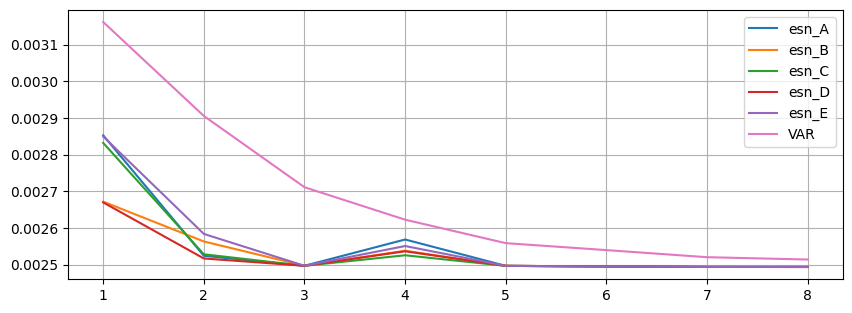

In [247]:
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.grid()
plt.plot(hStepRMSFE(esn_a_multi_for), label="esn_A", c="C0") 
plt.plot(hStepRMSFE(esn_b_multi_for), label="esn_B", c="C1") 
plt.plot(hStepRMSFE(esn_c_multi_for), label="esn_C", c="C2") 
plt.plot(hStepRMSFE(esn_d_multi_for), label="esn_D", c="C3")
plt.plot(hStepRMSFE(esn_e_multi_for), label="esn_E", c="C4")
# plt.plot(hStepRMSFE(ar_multi_direct), label="ARX", c="C5") 
plt.plot(hStepRMSFE(var_multi_fore), label="VAR", c="C6")
plt.legend()

### EW - Direct Multistep

#### ESN

In [231]:
def esn_multistep_ew(esnModel, Lambda, GDP_data, exo_data, steps):
    GDP_fill_data_train = GDP_data[0]
    GDP_fill_data_test = GDP_data[1]

    x_train = exo_data[0]
    x_test = exo_data[1]

    GDP_test_dates = GDP_fill_data_test.index

    forecast_ew = np.zeros((len(GDP_test_dates), steps))
    W_list = []
    L_list = []

    for j in tqdm(range(len(GDP_fill_data_test)), desc="EW", position=1, leave=False):
        if j > 0:
            #update data sets    
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:j,]
            ])
            x_train_j = pd.concat([
                x_train, 
                x_test.iloc[0:j,]
            ])
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            x_test_j = x_test.iloc[[j],]
        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            x_train_j = x_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            x_test_j = x_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        x_train_j, x_test_j = (
            normalize_train_test(x_train_j, x_test_j)
        )

        #fit model
        esn_fit_multi = esnModel.fitDirectMultistep(
            train_data = (x_train_j, GDP_fill_data_train_j), 
            method= ridgeFit(Lambda), 
            steps =steps)
        
        #forecast
        esn_for = forecastDirectMultistep(
            model = esnModel, 
            forecast_data = x_test_j, 
            fit= esn_fit_multi)

        #undo normalizing 
        forecast_ew[j, :] = (esn_for['forecast'][0]* sig_j.to_numpy()).flatten()+ mu_j.to_numpy()
      
    
    #output
    return({'Lambda': Lambda,  
            'forecast':forecast_ew,
            'fit': esn_fit_multi})
   

In [232]:
esn_a_multi_ew= esn_multistep_ew(esn_a, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], steps= 8, Lambda= esn_a_multistep['Lambda'])

In [233]:
esn_b_multi_ew= esn_multistep_ew(esn_b, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], steps= 8, Lambda= esn_a_multistep['Lambda'])

In [234]:
esn_c_multi_ew= esn_multistep_ew(esn_c, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], steps= 8, Lambda= esn_a_multistep['Lambda'])

In [235]:
esn_d_multi_ew= esn_multistep_ew(esn_d, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], steps= 8, Lambda= esn_a_multistep['Lambda'])

In [236]:
esn_e_multi_ew= esn_multistep_ew(esn_e, GDP_data= [GDP_fill_data_train, GDP_fill_data_test], exo_data=[x_train,x_test], steps= 8, Lambda= esn_a_multistep['Lambda'])

In [237]:
esn_a_multi_ew_for = np.squeeze(esn_a_multi_ew['forecast'])
esn_a_multi_ew_for = pd.DataFrame(esn_a_multi_ew_for)
# display(esn_a_multi_ew_for)
print('RMSE for A:',hStepRMSFE(esn_a_multi_ew_for))

esn_b_multi_ew_for = np.squeeze(esn_b_multi_ew['forecast'])
esn_b_multi_ew_for = pd.DataFrame(esn_b_multi_ew_for)
# display(esn_a_multi_ew_for)
print('RMSE for B:',hStepRMSFE(esn_b_multi_ew_for))

esn_c_multi_ew_for = np.squeeze(esn_c_multi_ew['forecast'])
esn_c_multi_ew_for = pd.DataFrame(esn_c_multi_ew_for)
print('RMSE for C:',hStepRMSFE(esn_c_multi_ew_for))

esn_d_multi_ew_for = np.squeeze(esn_d_multi_ew['forecast'])
esn_d_multi_ew_for = pd.DataFrame(esn_d_multi_ew_for)
print('RMSE for D:',hStepRMSFE(esn_d_multi_ew_for))

esn_e_multi_ew_for = np.squeeze(esn_e_multi_ew['forecast'])
esn_e_multi_ew_for = pd.DataFrame(esn_e_multi_ew_for)
print('RMSE for E:',hStepRMSFE(esn_e_multi_ew_for))


RMSE for A:           0
1  0.002824
2  0.002525
3  0.002500
4  0.002555
5  0.002500
6  0.002499
7  0.002497
8  0.002497
RMSE for B:           0
1  0.002806
2  0.002547
3  0.002500
4  0.002582
5  0.002500
6  0.002499
7  0.002497
8  0.002497
RMSE for C:           0
1  0.002843
2  0.002533
3  0.002500
4  0.002555
5  0.002500
6  0.002499
7  0.002497
8  0.002497
RMSE for D:           0
1  0.002797
2  0.002548
3  0.002500
4  0.002598
5  0.002500
6  0.002499
7  0.002497
8  0.002497
RMSE for E:           0
1  0.003002
2  0.002588
3  0.002500
4  0.002621
5  0.002500
6  0.002499
7  0.002497
8  0.002497


#### AR

In [238]:
# direct multi-step using AR(1)
# Expanding window method 
def ar_directmultistep(steps, data):
    
    GDP_data_train = data[0]
    GDP_data_test = data[1]
    # x_train, x_test = data[0].iloc[:, 1:], data[1].iloc[:, 1:]
    GDP_test_dates = GDP_data_test.index
    
    # Change the index of the DataFrame
    # new_index = range(len(x_train), len(x_train)+ len(x_test))
    # GDP_test_series = GDP_fill_data_test.set_index(pd.Index(new_index))
    GDP_test_series = pd.Series(GDP_data_test.values.flatten())
    GDP_train_series = pd.Series(GDP_data_train.values.flatten())

    pred = np.zeros((len(x_test),steps))

    forecaster = ForecasterAutoregDirect(
                    regressor = LinearRegression(),
                    lags  = 1,
                    steps = steps)
    
    for j in range (len(GDP_data_test)): 
        forecaster.fit(y= GDP_train_series)
        # exog = x_train.reset_index().iloc[:,1:4]
        pred[j] = forecaster.predict(steps=8)
        GDP_train_series = GDP_train_series._append(pd.Series(GDP_test_series[j]),  ignore_index=True)

    return pd.DataFrame(data=pred, index=GDP_test_dates, columns=range(steps))


In [239]:
warnings.filterwarnings("ignore")
ar_multi_direct_ew = ar_directmultistep(steps =8, data=[GDP_fill_data_train, GDP_fill_data_test])
warnings.resetwarnings()

hStepRMSFE(ar_multi_direct_ew)

,0
1,0.002849
2,0.002716
3,0.002535
4,0.002497
5,0.002521
6,0.002519
7,0.002499
8,0.002509


#### VAR

In [248]:
def var_multi_ew(steps, data): 
    train = data[0]
    test = data[1]
    GDP_data_train = data[0]['GDP']
    GDP_data_test = data[1]['GDP']
    x_train, x_test = data[0].iloc[:, 1:], data[1].iloc[:, 1:]
    GDP_test_dates = GDP_data_test.index

    # set up model
    var_model = sm.tsa.VAR(data[0])
    var_fit = var_model.fit(1)

    # forecast multistep 
    var_forecast = np.zeros((len(test), steps))
    for i in range(len(test)):
        if i > 0:
            # update dataset
            train_i = pd.concat([train, test.iloc[0:i,]], axis =0)
           
            var_model = sm.tsa.VAR(train_i)
            var_fit = var_model.fit(1)
            var_fore = var_fit.forecast(test.values[[i-1]], steps)
            var_forecast[i, :]= var_fore[:,0] # get GDP forecast

        else:
            var_fore = var_fit.forecast(train.values[-1:], steps)
            var_forecast[i, :]= var_fore[:,0]

    return pd.DataFrame(data=var_forecast, index=GDP_test_dates, columns=range(steps))

In [249]:
warnings.filterwarnings("ignore")
var_multi_for_ew = var_multi_ew(steps =8, data=[data_new_train, data_new_test])
hStepRMSFE(var_multi_for_ew)

,0
1,0.003125
2,0.002894
3,0.002735
4,0.002641
5,0.002574
6,0.002549
7,0.002523
8,0.002515


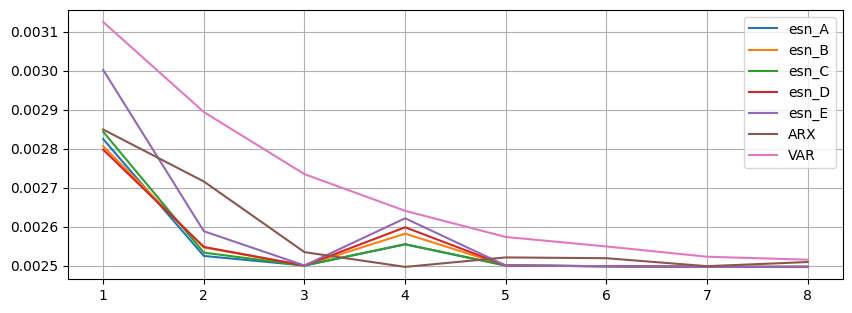

In [250]:
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.grid()
plt.plot(hStepRMSFE(esn_a_multi_ew_for), label="esn_A", c="C0") 
plt.plot(hStepRMSFE(esn_b_multi_ew_for), label="esn_B", c="C1") 
plt.plot(hStepRMSFE(esn_c_multi_ew_for), label="esn_C", c="C2") 
plt.plot(hStepRMSFE(esn_d_multi_ew_for), label="esn_D", c="C3")
plt.plot(hStepRMSFE(esn_e_multi_ew_for), label="esn_E", c="C4")
plt.plot(hStepRMSFE(ar_multi_direct_ew), label="ARX", c="C5")
plt.plot(hStepRMSFE(var_multi_for_ew), label="VAR", c="C6") 
plt.legend()

### RW - Multistep

#### ESN

#### AR

In [241]:
# direct multi-step using AR(1)
# Rolling window method 
def ar_directmultistep_RW(steps, data):
    
    GDP_data_train = data[0]
    GDP_data_test = data[1]
    # x_train, x_test = data[0].iloc[:, 1:], data[1].iloc[:, 1:]
    GDP_test_dates = GDP_data_test.index
    
    # Change the index of the DataFrame
    GDP_test_series = pd.Series(GDP_data_test.values.flatten())
    GDP_train_series = pd.Series(GDP_data_train.values.flatten())

    pred = np.zeros((len(x_test),steps))

    forecaster = ForecasterAutoregDirect(
                    regressor = LinearRegression(),
                    lags  = 1,
                    steps = steps)
    
    for j in range (len(GDP_data_test)): 
        forecaster.fit(y= GDP_train_series)
        # exog = x_train.reset_index().iloc[:,1:4]
        pred[j] = forecaster.predict(steps=8)
        GDP_train_series = GDP_train_series._append(pd.Series(GDP_test_series[j]),  ignore_index=True)
        GDP_train_series = GDP_train_series[1:]
        

    return pd.DataFrame(data=pred, index=GDP_test_dates, columns=range(steps))

In [242]:
warnings.filterwarnings("ignore")
ar_multi_rw = ar_directmultistep_RW(steps =8, data=[GDP_fill_data_train, GDP_fill_data_test])
warnings.resetwarnings()

hStepRMSFE(ar_multi_rw)

,0
1,0.002822
2,0.002707
3,0.002535
4,0.002514
5,0.002552
6,0.002573
7,0.002553
8,0.002542


### Comparison 
- model confidence set
- pairwise Modified Diehold-Mariano test
    - H0: 2 set of forecasts have the same accuracy
    - H1: different level of accuracy

Prepare the dataset and conduct the tests in R

In [243]:
mcs_data_fix = pd.DataFrame(np.c_[arx_forecast.values, var_forecast[:,0], esn_fit_a['forecast'][0:49], esn_fit_b['forecast'][0:49], esn_fit_c['forecast'][0:49], esn_fit_d['forecast'][0:49], esn_fit_e['forecast'][0:49] ], columns = ['ARX', 'VAR', 'ESN_A', 'ESN_B', 'ESN_C', 'ESN_D', 'ESN_E'])

mcs_data_fix.index = data_new_test.index
mcs_data_fix.to_csv('MCS_Fix.csv', index=True)

mcs_data_fix = mcs_data_fix - GDP_fill_data_test.to_numpy()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 18 and the array at index 2 has size 19

In [ ]:
mcs_25_fix = ModelConfidenceSet(data = np.square(mcs_data_fix), alpha=0.25, B=10000, w=2, algorithm='R', seed=1234
).run()

mcs_10_fix = ModelConfidenceSet(
    data=np.square(mcs_data_fix), alpha=0.10, B=10000, w=2, algorithm='R', seed=1234
).run()

print(f"MCS 25 included: {mcs_25_fix.included}")
print(f"MCS 10 included: {mcs_10_fix.included}")

mcs_25_fix.pvalues

In [ ]:
mcs_data_ew = pd.DataFrame(np.c_[arx_fore_ew, var_fore_ew,esn_A_ew['forecast'], esn_B_ew['forecast'], esn_C_ew['forecast'], esn_D_ew['forecast'], esn_E_ew['forecast'] ], columns = ['ARX', 'VAR','ESN_A', ' ESN_B', 'ESN_C', 'ESN_D', 'ESN_E'])

mcs_data_ew.index = data_new_test.index
mcs_data_ew.to_csv('MCS_EW.csv', index=True)

In [ ]:
mcs_data_rw = pd.DataFrame(np.c_[arx_fore_rw, var_fore_rw, esn_A_rw['forecast'], esn_B_rw['forecast'], esn_C_rw['forecast'], esn_D_rw['forecast'], esn_E_rw['forecast'] ], columns = ['ARX','VAR', 'ESN_A', ' ESN_B', 'ESN_C', 'ESN_D', 'ESN_E'])

mcs_data_rw.index = data_new_test.index
mcs_data_rw.to_csv('MCS_RW.csv', index=True)

In [ ]:
# save all multi-step forecasts into csv files 
esn_a_multi_for.to_csv('multi_fore_ESN_A.csv', index=True)
esn_b_multi_for.to_csv('multi_fore_ESN_B.csv', index=True)
esn_c_multi_for.to_csv('multi_fore_ESN_C.csv', index=True)
esn_d_multi_for.to_csv('multi_fore_ESN_D.csv', index=True)
esn_e_multi_for.to_csv('multi_fore_ESN_E.csv', index=True)
arx_multi_fore.to_csv('multi_fore_ARX.csv', index=True)
var_multi_fore.to_csv('multi_fore_VAR.csv', index=True)
